In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim

for dirname, _, filenames in os.walk("./data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/Plant_2_Generation_Data.csv
./data/Plant_1_Generation_Data.csv
./data/Plant_2_Weather_Sensor_Data.csv
./data/Plant_1_Weather_Sensor_Data.csv


## Data Processing


In [2]:
df_plt1_gen = pd.read_csv("./data/Plant_1_Generation_Data.csv")

In [3]:
df_plt1_gen["DATE_TIME"] = pd.to_datetime(df_plt1_gen["DATE_TIME"], dayfirst=True)

# 为了查看每个设备或发电单元（SOURCE_KEY）的记录数量，并按照数量进行排序
df_plt1_gen.groupby("SOURCE_KEY").count().DATE_TIME.sort_values()

SOURCE_KEY
YxYtjZvoooNbGkE    3104
3PZuoBAID5Wc2HD    3118
WRmjgnKYAwPKWDb    3118
adLQvlD726eNBSB    3119
1IF53ai7Xc0U56Y    3119
zBIq5rxdHJRwDNY    3119
ZoEaEvLYb1n2sOq    3123
sjndEbLyjtCKgGv    3124
rGa61gmuvPhdLxV    3124
zVJPv84UY57bAof    3124
McdE0feGgRqW7Ca    3124
iCRJl6heRkivqQ3    3125
pkci93gMrogZuBj    3125
uHbuxQJl8lW7ozc    3125
wCURE6d3bPkepu2    3126
z9Y9gH1T5YWrNuG    3126
ih0vzX44oOqAx2f    3130
ZnxXDlPa8U1GXgE    3130
VHMLBKoKgIrUVDU    3133
7JYdWkrLSPkdwr4    3133
1BY6WEcLGh8j5v7    3154
bvBOhCH3iADSZry    3155
Name: DATE_TIME, dtype: int64

In [4]:
d1 = df_plt1_gen["DATE_TIME"].unique()
print(d1.shape)

d2 = df_plt1_gen[df_plt1_gen["SOURCE_KEY"] == "1BY6WEcLGh8j5v7"]["DATE_TIME"].unique()
print(d2.shape)

df1 = pd.DataFrame(d1)
df2 = pd.DataFrame(d2)

(3158,)
(3154,)


In [5]:
df_plt1_weather = pd.read_csv("./data/Plant_1_Weather_Sensor_Data.csv")

df_plt1_weather.describe(include="all").T

df_weather = df_plt1_weather.drop(["PLANT_ID", "SOURCE_KEY"], axis=1)

df_weather["DATE_TIME"] = pd.to_datetime(
    df_weather.DATE_TIME, format="%Y-%m-%d %H:%M:%S"
)

In [6]:
# datetimes_full 这个序列表示从数据集中最早的时间到最晚的时间，以15分钟为间隔的完整时间序列。这个完整时间序列包括了可能在原始天气数据中未出现的时间点，有助于识别数据集中的时间间隙
datetimes_w = df_weather["DATE_TIME"].unique()

datetimes_full = pd.Series(
    pd.date_range(df_weather.DATE_TIME.min(), df_weather.DATE_TIME.max(), freq="15min"),
    name="DATE_TIME",
)
datetimes_full

0      2020-05-15 00:00:00
1      2020-05-15 00:15:00
2      2020-05-15 00:30:00
3      2020-05-15 00:45:00
4      2020-05-15 01:00:00
               ...        
3259   2020-06-17 22:45:00
3260   2020-06-17 23:00:00
3261   2020-06-17 23:15:00
3262   2020-06-17 23:30:00
3263   2020-06-17 23:45:00
Name: DATE_TIME, Length: 3264, dtype: datetime64[ns]

In [7]:
# sourceKey -> inverter
df_gen = df_plt1_gen.drop("PLANT_ID", axis=1)
df_gen["INVERTER"] = df_gen.SOURCE_KEY.map(
    {
        df_gen.SOURCE_KEY.unique()[i - 1]: f"INVERTER_{i}"
        for i in range(1, len(df_gen.SOURCE_KEY.unique()) + 1)
    }
)
df_gen = df_gen.drop("SOURCE_KEY", axis=1)
inverters = df_gen.INVERTER.unique()
inverters

array(['INVERTER_1', 'INVERTER_2', 'INVERTER_3', 'INVERTER_4',
       'INVERTER_5', 'INVERTER_6', 'INVERTER_7', 'INVERTER_8',
       'INVERTER_9', 'INVERTER_10', 'INVERTER_11', 'INVERTER_12',
       'INVERTER_13', 'INVERTER_14', 'INVERTER_15', 'INVERTER_16',
       'INVERTER_17', 'INVERTER_18', 'INVERTER_19', 'INVERTER_20',
       'INVERTER_21', 'INVERTER_22'], dtype=object)

In [8]:
# 整合和填充每个逆变器在完整时间序列上的数据，确保数据集包含每个时间点上所有逆变器的记录，即使某些时间点上没有实际的发电数据
dfs_gen = []
for i in inverters:
    df_inverter = df_gen[df_gen.INVERTER == i]
    df_inverter = df_inverter.merge(datetimes_full, on="DATE_TIME", how="right")
    df_inverter["INVERTER"] = i
    dfs_gen.append(df_inverter)
df_gen = pd.concat(dfs_gen)

In [9]:
df = df_gen.merge(df_weather, on="DATE_TIME", how="left")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71808 entries, 0 to 71807
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            71808 non-null  datetime64[ns]
 1   DC_POWER             68778 non-null  float64       
 2   AC_POWER             68778 non-null  float64       
 3   DAILY_YIELD          68778 non-null  float64       
 4   TOTAL_YIELD          68778 non-null  float64       
 5   INVERTER             71808 non-null  object        
 6   AMBIENT_TEMPERATURE  70004 non-null  float64       
 7   MODULE_TEMPERATURE   70004 non-null  float64       
 8   IRRADIATION          70004 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 5.5+ MB


In [10]:
df["HOUR"] = df.DATE_TIME.dt.hour
df["DAY"] = df.DATE_TIME.dt.dayofyear
df["DAY_WEEK"] = df.DATE_TIME.dt.dayofweek
df["MINUTES_15"] = df.DATE_TIME.dt.time

# This maps the 15 minute intervals over the course of the day to ints 1-96.
df["MINUTES_15"] = df.MINUTES_15.map(
    {df.MINUTES_15.unique()[i - 1]: i for i in range(1, 97)}
)
# Change day of year to day of data
df["DAY"] = df.DAY.map({df.DAY.unique()[i - 1]: i for i in range(1, 35)})

print(df.shape, df.head())

(71808, 13)             DATE_TIME  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15 00:00:00       0.0       0.0          0.0    6259559.0   
1 2020-05-15 00:15:00       0.0       0.0          0.0    6259559.0   
2 2020-05-15 00:30:00       0.0       0.0          0.0    6259559.0   
3 2020-05-15 00:45:00       0.0       0.0          0.0    6259559.0   
4 2020-05-15 01:00:00       0.0       0.0          0.0    6259559.0   

     INVERTER  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  HOUR  \
0  INVERTER_1            25.184316           22.857507          0.0     0   
1  INVERTER_1            25.084589           22.761668          0.0     0   
2  INVERTER_1            24.935753           22.592306          0.0     0   
3  INVERTER_1            24.846130           22.360852          0.0     0   
4  INVERTER_1            24.621525           22.165423          0.0     1   

   DAY  DAY_WEEK  MINUTES_15  
0    1         4           1  
1    1         4           2  
2    

<Axes: >

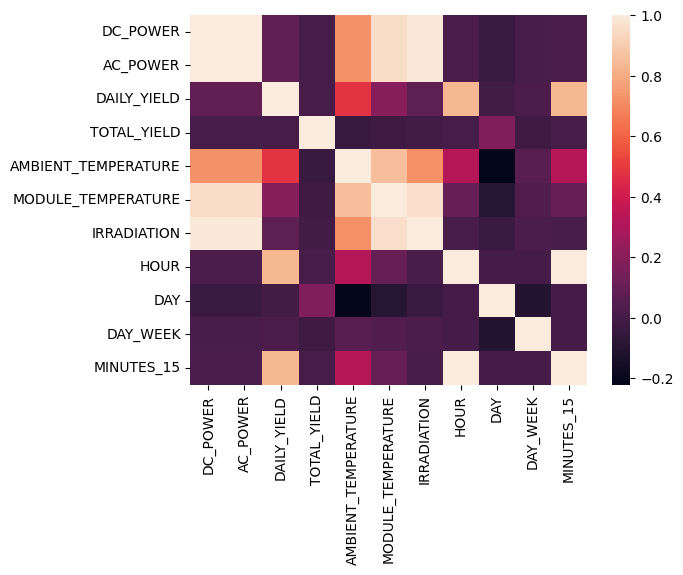

In [11]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr)

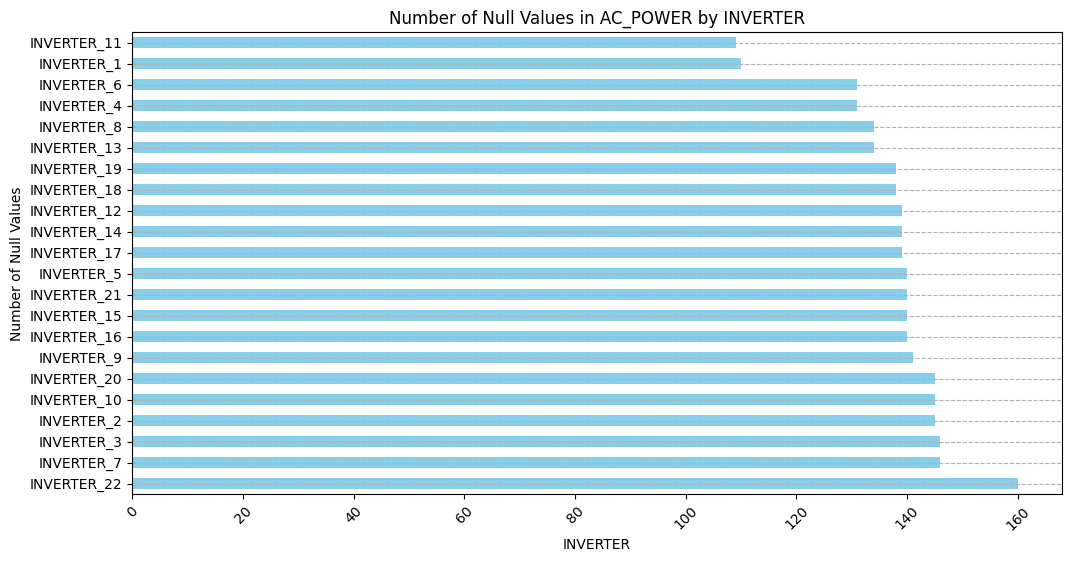

In [12]:
# 计算每个INVERTER中的空值数量
null_counts = df.isnull().groupby(df["INVERTER"]).sum()

# 选择一个列来展示每个INVERTER空值的数量，这里假设我们关注的是某个特定的列，比如'DC_POWER'
null_counts_dc_power = null_counts["AC_POWER"].sort_values(ascending=False)

# 绘图
plt.figure(figsize=(12, 6))
null_counts_dc_power.plot(kind="barh", color="skyblue")
plt.title("Number of Null Values in AC_POWER by INVERTER")
plt.xlabel("INVERTER")
plt.ylabel("Number of Null Values")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--")
plt.show()

## Data Picking


In [13]:
inverter_example = "INVERTER_11"

sample_data = df[df["INVERTER"] == inverter_example]

missing_values = sample_data.isnull().sum()
print(missing_values)

sample_data.fillna(method="ffill", inplace=True)

print(sample_data.head())

missing_values = sample_data.isnull().sum()
print(missing_values)

DATE_TIME                0
DC_POWER               109
AC_POWER               109
DAILY_YIELD            109
TOTAL_YIELD            109
INVERTER                 0
AMBIENT_TEMPERATURE     82
MODULE_TEMPERATURE      82
IRRADIATION             82
HOUR                     0
DAY                      0
DAY_WEEK                 0
MINUTES_15               0
dtype: int64
                DATE_TIME  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
32640 2020-05-15 00:00:00       0.0       0.0          0.0    6316803.0   
32641 2020-05-15 00:15:00       0.0       0.0          0.0    6316803.0   
32642 2020-05-15 00:30:00       0.0       0.0          0.0    6316803.0   
32643 2020-05-15 00:45:00       0.0       0.0          0.0    6316803.0   
32644 2020-05-15 01:00:00       0.0       0.0          0.0    6316803.0   

          INVERTER  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
32640  INVERTER_11            25.184316           22.857507          0.0   
32641  INVERTER_11            25.

/var/folders/mf/1zht4rt167l4nwkf7l1df8rh0000gn/T/ipykernel_23958/2778204162.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data.fillna(method="ffill", inplace=True)


<Axes: >

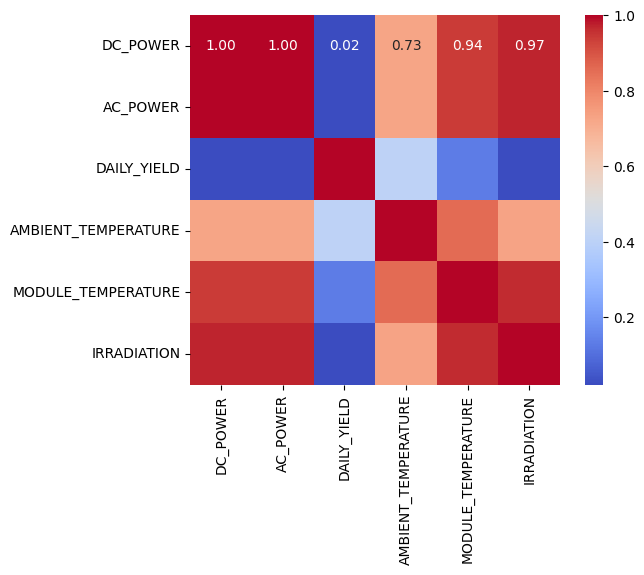

In [14]:
relevant_columns = [
    "DC_POWER",
    "AC_POWER",
    "DAILY_YIELD",
    "AMBIENT_TEMPERATURE",
    "MODULE_TEMPERATURE",
    "IRRADIATION",
]

correlation_matrix_1 = sample_data[relevant_columns].corr()
sns.heatmap(correlation_matrix_1, annot=True, cmap="coolwarm", fmt=".2f", square=True)

## Prediction


In [15]:
# Preparing features and target variable
features = sample_data[["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]]
target = sample_data["AC_POWER"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2611, 3) (2611,)
(653, 3) (653,)


In [16]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape, y_train.shape)

(2611, 3) (2611,)


### SVM


In [17]:
svm_model = SVR(kernel="rbf")

# Set the parameters by cross-validation
param_grid = {
    "C": np.logspace(-3, 3, 7),  # the value of C is chosen from the range [0.001, 1000]
}

# Using GridSearchCV to find the best parameters
grid_search = GridSearchCV(
    svm_model,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)

# Fitting the model
grid_search.fit(X_train_scaled, y_train)

# Predictions and Performance Evaluation
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_test_scaled)

# Calculating R^2 and MSE for the models
svm_r2 = r2_score(y_test, y_pred_svm) * 100
mse_svm = mean_squared_error(y_test, y_pred_svm)

print(f"SVM Model R^2 = {svm_r2:4.4f}")
print(f"SVM Model MSE = {mse_svm:4.4f}")

SVM Model R^2 = 93.0734
SVM Model MSE = 8941.0008


[200517.03279365 196611.90822413 159326.74972055  25221.80297528
   7032.54786486   6810.24630235   6804.71305767] [200164.83407168 196262.55875497 159150.42368008  25131.76568047
   6944.4787766    6687.91557807   6681.98424918]


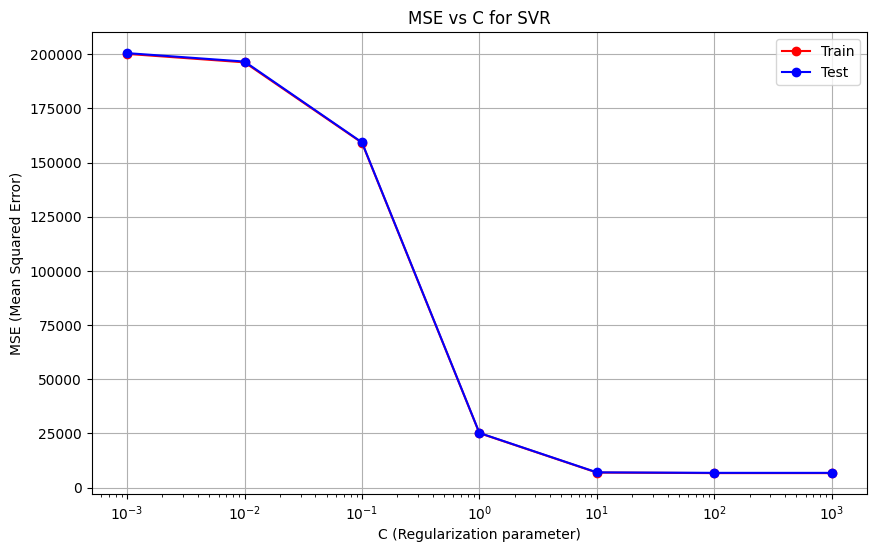

In [18]:
C_range = grid_search.param_grid["C"]
mse_train_scores = grid_search.cv_results_["mean_train_score"]
mse_scores = grid_search.cv_results_["mean_test_score"]

# transform the scores to positive
mse_scores = np.abs(mse_scores)
mse_train_scores = np.abs(mse_train_scores)

print(mse_scores, mse_train_scores)

# output the best C value
plt.figure(figsize=(10, 6))
plt.plot(
    C_range, mse_train_scores, marker="o", linestyle="-", color="red", label="Train"
)
plt.plot(C_range, mse_scores, marker="o", linestyle="-", color="blue", label="Test")
plt.xscale("log")
plt.xlabel("C (Regularization parameter)")
plt.ylabel("MSE (Mean Squared Error)")
plt.title("MSE vs C for SVR")
plt.grid(True)
plt.legend()
plt.show()

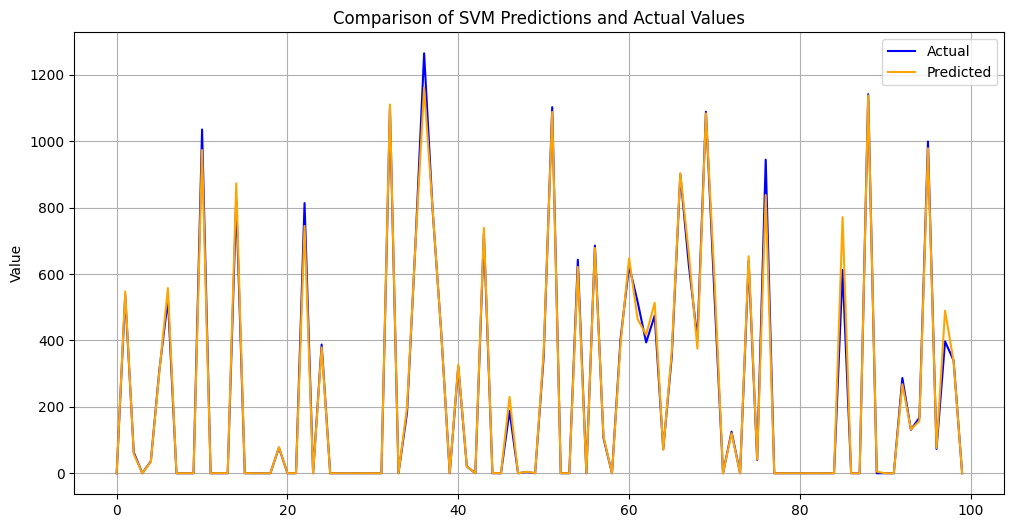

In [19]:
sample_size = 100
y_test_array = y_test.values.reshape(-1, 1)
y_pred_svm_array = y_pred_svm.reshape(-1, 1)

plt.figure(figsize=(12, 6))
plt.plot(
    range(sample_size),
    y_test_array[:sample_size],
    label="Actual",
    color="blue",
)
plt.plot(
    range(sample_size),
    y_pred_svm_array[:sample_size],
    label="Predicted",
    color="orange",
)

plt.title("Comparison of SVM Predictions and Actual Values")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

### GBDT


In [20]:
# GBDT Model Training
gbdt_model = GradientBoostingRegressor()

# Set the parameters
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
}

grid_search = GridSearchCV(
    estimator=gbdt_model, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)

grid_search.fit(X_train_scaled, y_train)

# Predictions and Performance Evaluation
best_gbdt_model = grid_search.best_estimator_
y_pred_gbdt = best_gbdt_model.predict(X_test_scaled)

# Calculating R^2 and MSE for the models
gbdt_r2_score = r2_score(y_test, y_pred_gbdt) * 100
mse_gbdt = mean_squared_error(y_test, y_pred_gbdt)

print(f"GBDT Model R^2 score = {gbdt_r2_score:4.4f}")
print(f"GBDT Model MSE = {mse_gbdt:4.4f}")

GBDT Model R^2 score = 93.1579
GBDT Model MSE = 8831.9764


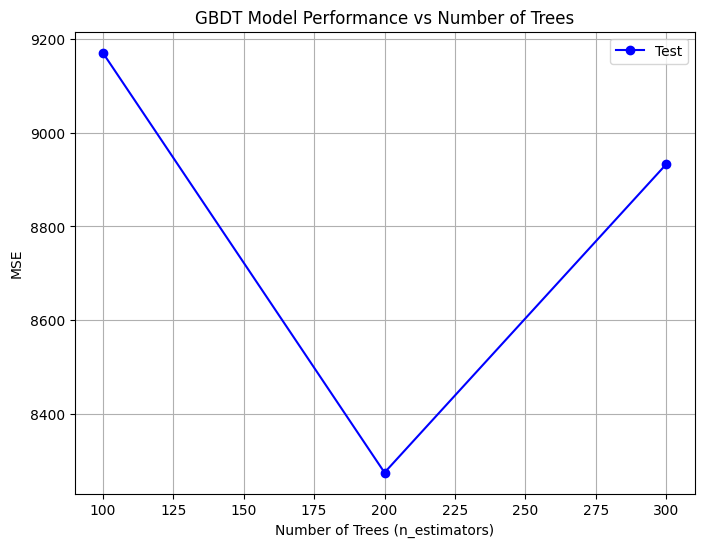

In [21]:
n_estimators_range = param_grid["n_estimators"]
mean_scores = np.array(grid_search.cv_results_["mean_test_score"]).reshape(
    len(n_estimators_range), -1, len(param_grid["max_depth"])
)

mean_scores = np.abs(mean_scores)

lr_index = param_grid["learning_rate"].index(0.1)
md_index = param_grid["max_depth"].index(4)
scores = mean_scores[:, lr_index, md_index]

plt.figure(figsize=(8, 6))
plt.plot(n_estimators_range, scores, marker="o", color="blue", label="Test")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("MSE")
plt.title("GBDT Model Performance vs Number of Trees")
plt.grid(True)
plt.legend()
plt.show()

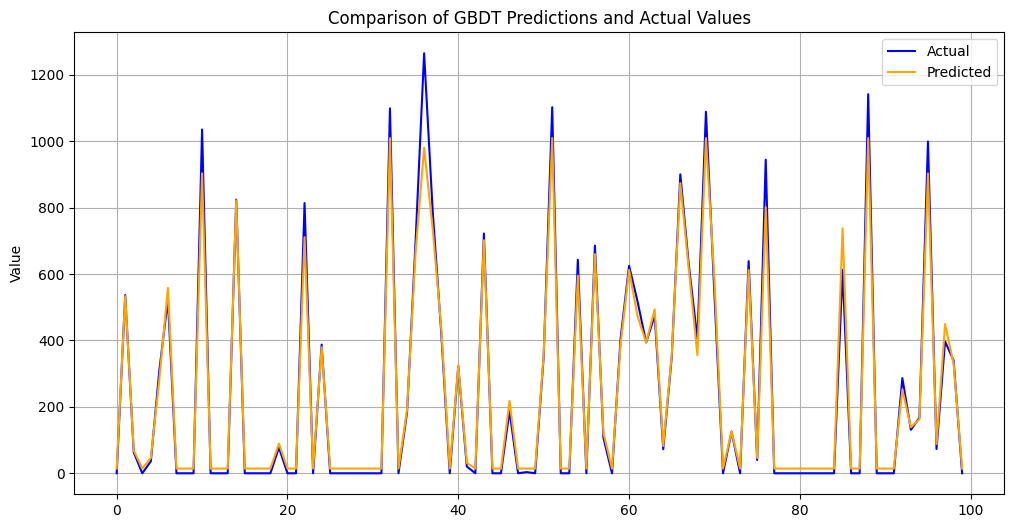

In [22]:
sample_size = 100
y_test_array = y_test.values.reshape(-1, 1)
y_pred_gbdt_array = y_pred_gbdt.reshape(-1, 1)

plt.figure(figsize=(12, 6))
plt.plot(
    range(sample_size),
    y_test_array[:sample_size],
    label="Actual",
    color="blue",
)
plt.plot(
    range(sample_size),
    y_pred_gbdt_array[:sample_size],
    label="Predicted",
    color="orange",
)

plt.title("Comparison of GBDT Predictions and Actual Values")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

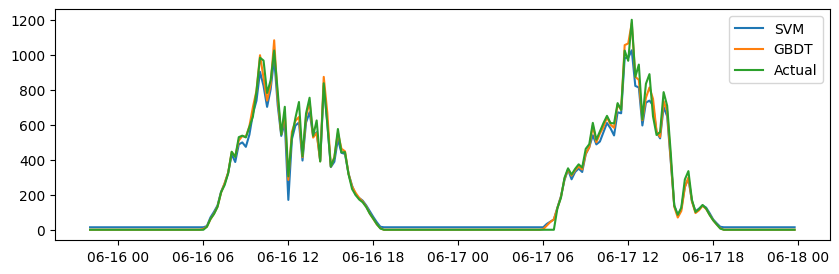

In [23]:
test = sample_data.tail(200)[
    ["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]
]
target = sample_data.tail(200)["AC_POWER"]
y_pred_gbdt = best_svm_model.predict(scaler.transform(test))
y_pred_svm = best_gbdt_model.predict(scaler.transform(test))

plt.figure(figsize=[10, 3])
plt.plot(sample_data["DATE_TIME"].tail(200), y_pred_svm, label="SVM")
plt.plot(sample_data["DATE_TIME"].tail(200), y_pred_gbdt, label="GBDT")
plt.plot(sample_data["DATE_TIME"].tail(200), target, label="Actual")
plt.legend()

### NNet


In [24]:
# X_train_torch = torch.tensor(X_train_scaled.astype(np.float32))
# y_train_torch = torch.tensor(y_train.values.astype(np.float32))
# X_test_torch = torch.tensor(X_test_scaled.astype(np.float32))
# y_test_torch = torch.tensor(y_test.values.astype(np.float32))


# train_data = TensorDataset(X_train_torch, y_train_torch)
# test_data = TensorDataset(X_test_torch, y_test_torch)

# batch_size = 64
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [25]:
# class NNet(nn.Module):

#     def __init__(self, input_size, hidden_size, output_size):
#         super(NNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.fc2 = nn.ReLU()
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.fc4 = nn.ReLU()
#         self.fc5 = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         x = self.fc4(x)
#         x = self.fc5(x)
#         return x


# model = NNet(3, 128, 1)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# epochs = 200
# for epoch in range(epochs):
#     model.train()
#     for data, target in train_loader:
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target.view(-1, 1))
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


# # Model Evaluation
# model.eval()
# predictions = []
# targets = []

# with torch.no_grad():
#     for data, target in test_loader:
#         output = model(data)
#         predictions.extend(output.view(-1).tolist())
#         targets.extend(target.tolist())

# nnet_r2 = r2_score(targets, predictions) * 100
# print(f"NNet R^2 Score: {nnet_r2}")

In [26]:
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size)
#         self.hidden2out = nn.Linear(hidden_size, output_size)

#     def forward(self, input):
#         lstm_out, _ = self.lstm(input.view(len(input), 1, -1))
#         output = self.hidden2out(lstm_out.view(len(input), -1))
#         return output


# model = LSTM(3, 128, 1)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# epochs = 200
# for epoch in range(epochs):
#     model.train()
#     for data, target in train_loader:
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target.view(-1, 1))
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


# # Model Evaluation
# model.eval()
# predictions = []
# targets = []

# with torch.no_grad():
#     for data, target in test_loader:
#         output = model(data)
#         predictions.extend(output.view(-1).tolist())
#         targets.extend(target.tolist())

# lstm_r2 = r2_score(targets, predictions) * 100
# print(f"LSTM R^2 Score: {lstm_r2}")